In [35]:
import pandas as pd
import pickle
import utils

In [151]:
from imp import reload
reload(utils)
reload(nlp_utils)

<module 'nlp_utils' from '/home/ai_prj/1_users/thkim/coreapi/nlp_utils.py'>

'# Example invocation
'## init 
endpoint = 'https://core.ac.uk/api-v2'


'## Add your own api key below
api_key = 'b9SZ0xWXdo72hKN4n3eAzDs5kYwM6BQL'

#method = '/articles/search'
method = '/search'
topic = 'dielectric AND constant AND polymer'

api = utils.CoreApiRequestor(endpoint,api_key) # CoreApiRequestor 클래스 객체 생성

'# Get url
url = api.get_method_query_request_url(method,topic,True,10,2010) #(self,method,query,fullText,page,from_date='>2001-01-01')

'# Get results
result = api.request_url(url)

result_as_json = json.loads(result.decode('utf-8'))

print('Total Hits :', result_as_json['totalHits'])

#multi_page_result = api.get_all_pages_of_query(method,topic,False)
#multi_page_result = api.get_up_to_20_pages_of_query(method,topic,False)

In [3]:
with open('articles_with_ft_only_ondielectricANDconstantANDpolymer.pkl', 'rb') as f:
    articles_with_ft_only = pickle.load(f)

In [60]:
df = utils.To_pd_DF(articles_with_ft_only)

#topic = 'deep AND learning'
ftopic = topic.replace(" ","")

queryOnlyFT = '(title:('+topic+') OR description:('+topic+') OR fullText:('+topic+')) AND fullText:*'
query = '(title:('+topic+') OR description:('+topic+') OR fullText:('+topic+'))'

'# fetch all articles (with or without fulltext) matching topic query in title or abstract or fulltext
try:
    all_articles = pickle.load(open('all_articles_on'+ftopic+'.pkl','rb'))
except (OSError,IOError) as e:
    all_articles = api.get_up_to_20_pages_of_query(method,query,False)
    pickle.dump(all_articles,open('all_articles_on'+ftopic+'.pkl','wb'),pickle.HIGHEST_PROTOCOL)

'# fetch articles only with fulltext (filter) matching topic query in title or abstract or fulltext
try:
    articles_with_ft_only = pickle.load(open('articles_with_ft_only_on'+ftopic+'.pkl','rb'))
except (OSError,IOError) as e:
    articles_with_ft_only = api.get_up_to_20_pages_of_query(method,queryOnlyFT,False)
    pickle.dump(articles_with_ft_only,open('articles_with_ft_only_on'+ftopic+'.pkl','wb'),pickle.HIGHEST_PROTOCOL)

pprint.pprint(articles_with_ft_only)

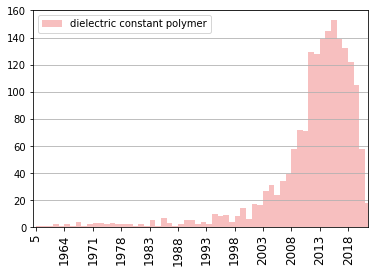

In [8]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

cnts = utils.year_profile_fromdf(df)

labels, values = zip(*sorted(cnts.items(), key=lambda x: x[0]))
indices = np.arange(len(labels))
fix, ax = plt.subplots()
ax.bar(indices+1, values, 1, color='lightcoral', alpha=0.5, label='dielectric constant polymer')
plt.xlim([0, indices.size])
plt.xticks(indices[0:-1:5]+0.5, labels[0:-1:5], fontsize=12, rotation='vertical')
plt.legend()
ax.yaxis.grid(True)

# NLP

In [30]:
import nltk
import gensim # # https://frhyme.github.io/python-libs/gensim1_doc2vec/

print ('NLTK ver: ', nltk.__version__)
print ('gensim ver: ', gensim.__version__)

import numpy as np
from math import log

NLTK ver:  3.5
gensim ver:  3.8.3


In [61]:
fulltext = df['fullText'].to_dict()
fulltext_list = list(df['fullText'])

In [62]:
import nlp_utils

In [ ]:
%%time
#tagged_documents, Doc2Vec_model = DocuVec(desc_docs, 5, 20, 50) # documents, vector, neg_sample, epochs
#tagged_documents, Doc2Vec_model = DocuVec(us_cla_list, 5, 20, 50) # documents, vector, neg_sample, epochs
tagged_documents, Doc2Vec_model = nlp_utils.DocuVec(fulltext_list, vector_size=50, min_count=10, cores=16, window=10, neg_sample=10, dm=0, dbow_words=1, epochs=50) # documents, vector, neg_sample, epochs

In [ ]:
#Save
Doc2Vec_model.save("Doc2Vec_model_DBOW.model")

#Load
#from gensim.models.doc2vec import Doc2Vec
#Doc2Vec_model = Doc2Vec.load("Doc2Vec_model.model")

In [186]:
Doc2Vec_model.corpus_total_words

347992

In [187]:
len(Doc2Vec_model.wv.vocab.keys())

3860

In [ ]:
import PyPDF2

text= ''

with open("./app.49778.pdf", "rb") as f:
    reader = PyPDF2.PdfFileReader(f)
    pages = reader.getNumPages() # PDF가 몇 페이지인지
    for i in range(pages):
        page = reader.getPage(i)
        text = text + page.extractText()
text

In [112]:
new_document_list = utils.string_preprocessing([text])

In [144]:
data = open('./papers/app.49778.txt', 'r+', encoding="utf-8")
strings = data.read()
data.close()
strings = list(strings.split('\n'))

new_document_list = [('\n'.join(strings)).replace('\n', ' ')]

In [188]:
for i in range(len(new_document_list)):
    new_document = new_document_list[i]
    new_doc_vector = Doc2Vec_model.infer_vector(new_document.lower().split(" "))
    print('Doc',i,':',Doc2Vec_model.wv.similar_by_vector(new_doc_vector)[:5])

Doc 0 : [('fgs', 0.6260925531387329), ('matrix', 0.625900387763977), ('hence,', 0.6213534474372864), ('cb/epoxy', 0.6186345219612122), ('nanocomposite', 0.6121194362640381)]


In [189]:
%%time
import numpy as np
size = len(new_document_list)
sim_mat = np.zeros((size, len(Doc2Vec_model.docvecs)))

for i in range(len(new_document_list)):
    #lst = DocuSim(Doc2Vec_model, list(us_cla.values())[i])
    #lst = DocuSim(Doc2Vec_model, list(us_summary.values())[i])
    lst = nlp_utils.DocuSim(Doc2Vec_model, new_document_list[i])
    for j in range(len(Doc2Vec_model.docvecs)):
        id_, sim = lst[j]
        
        sim_mat[i,id_] = sim
    #print(i)

# np.savetxt('sim_mat.csv',sim_mat,delimiter=",")

CPU times: user 251 ms, sys: 5 ms, total: 256 ms
Wall time: 255 ms


In [190]:
np.where(sim_mat[0]==max(sim_mat[0]))

(array([0]),)

In [191]:
sim_mat

array([[0.6262719 , 0.12200285, 0.13557249, 0.11884985, 0.24947503,
        0.24458353, 0.5918569 , 0.35396153, 0.31408256, 0.31367677,
        0.44352001, 0.43406823, 0.14709701, 0.16206351, 0.20003571,
        0.10065176, 0.24311377, 0.40428072, 0.41488749, 0.16125888,
        0.41000649, 0.41276768, 0.61076629, 0.35766178, 0.426442  ,
        0.30387157, 0.41013765, 0.29895675, 0.17498204, 0.18169178,
        0.18239504, 0.19842291, 0.17638063, 0.30216917, 0.186737  ,
        0.21822904, 0.32422268, 0.2286815 , 0.4610281 , 0.24509172,
        0.31561673, 0.21290867, 0.28976911, 0.28954968, 0.33830452,
        0.36736283, 0.22341435, 0.16296946, 0.17347628, 0.36649895]])

In [192]:
max(sim_mat[0])

0.6262719035148621

In [172]:
pd.set_option('display.max_columns', 100)

In [181]:
pd.set_option('display.max_columns', None)
df[5:6]
print(df['urls'][0])

['http://hdl.handle.net/1853/26666']


In [173]:
df

,index,id,authors,citations,contributors,datePublished,deleted,description,fullText,fullTextIdentifier,identifiers,journals,duplicateId,publisher,rawRecordXml,relations,repositories,similarities,subjects,title,topics,types,urls,year,doi,oai,downloadUrl,pdfHashValue,documentType,documentTypeConfidence,citationCount,estimatedCitationCount,acceptedDate,depositedDate,publishedDate,issn,attachmentCount,repositoryPublicReleaseDate,extendedMetadataAttributes,crossrefDocument,magDocument,orcidAuthors,language.code,language.id,language.name,repositoryDocument.pdfStatus,repositoryDocument.textStatus,repositoryDocument.metadataAdded,repositoryDocument.metadataUpdated,repositoryDocument.timestamp,repositoryDocument.depositedDate,repositoryDocument.indexed,repositoryDocument.deletedStatus,repositoryDocument.pdfSize,repositoryDocument.tdmOnly,repositoryDocument.pdfOrigin,language,extendedMetadataAttributes.attachmentCount,extendedMetadataAttributes.publicReleaseDate,crossrefDocument.doi,crossrefDocument.acceptedDate,crossrefDocument.publishedDate,crossrefDocument.depositedDate,crossrefDocument.issn,magDocument.magId,magDocument.citationsCount,magDocument.estimatedCitationsCount
0,1,4720018,"[Lu, Jiongxin]",[],[Materials Science and Engineering],2008-09-17T00:00:00,ALLOWED,Driven by ever growing demands of miniaturizat...,HIGH DIELECTRIC CONSTANT POLYMER NANOCOMPOSITE...,https://smartech.gatech.edu/bitstream/1853/266...,"[oai:smartech.gatech.edu:1853/26666, None]",None,None,Georgia Institute of Technology,<record><header><identifier>oai:smartech.gatec...,[],"[{'id': '193', 'openDoarId': 0, 'name': 'Schol...",None,[Dissertation],High dielectric constant polymer nanocomposite...,"[High dielectric constant, Embedded passives, ...",[],[http://hdl.handle.net/1853/26666],2008,None,oai:smartech.gatech.edu:1853/26666,https://core.ac.uk/download/4720018.pdf,54405920783be868f83d5e6d373a17385efdc713,thesis,1,None,None,None,1242946800000,1221609600000,None,0.0,None,None,None,None,None,en,9.0,English,1,1,1340296413000,1622511611000,1470776609000,1242946800000,1,0,5737433,False,https://smartech.gatech.edu/bitstream/1853/266...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2634018,"[Singh, Pramod Kumar, Chandra, Amreesh]",[],[],2003-04-21T00:00:00,ALLOWED,The dispersal of high dielectric constant ferr...,Role of the dielectric constant of ferroelectr...,http://arxiv.org/abs/physics/0304078,"[oai:arXiv.org:physics/0304078, 10.1088/0022-3...",None,None,'IOP Publishing',<record><header><identifier>\n\n\n oai:arXiv.o...,[],"[{'id': '144', 'openDoarId': 0, 'name': 'arXiv...",None,[text],Role of the dielectric constant of ferroelectr...,"[Physics - Chemical Physics, Physics - General...",[],[http://arxiv.org/abs/physics/0304078],2003,10.1088/0022-3727/36/19/L01,oai:arXiv.org:physics/0304078,http://arxiv.org/abs/physics/0304078,5b64b2f6598629f26a6a49c92243120f05b7d532,research,0.444444,None,None,None,1257811200000,1050883200000,None,0.0,None,None,None,None,None,en,9.0,English,1,1,1334323476000,1608826669000,1257811200000,1257811200000,1,0,128589,True,http://arxiv.org/abs/physics/0304078,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,79515937,"[Zhang, G, Clarke, TM, Mozer, AJ]",[],[],2016-04-07T00:00:00,ALLOWED,The strength of dielectric screening is one of...,1 Bimolecular recombination in a low bandga...,http://discovery.ucl.ac.uk/1493455/3/Clarke_DT...,"[oai:eprints.ucl.ac.uk.OAI2:1493455, None]",None,None,None,<record><header><identifier>\n \n \n ...,[],"[{'id': '118', 'openDoarId': 0, 'name': 'UCL D...",None,[Article],Bimolecular Recombination in a Low Bandgap Pol...,[],[],[https://discovery.ucl.ac.uk/id/eprint/1493455...,2016,10.1021/acs.jpcc.6b01169,oai:eprints.ucl.ac.uk.OAI2:1493455,https://core.ac.uk/download/79515937.pdf,8c562264489a665e2f97674bbdf00ca7346ef45d,research,1,13,13,1458518400000,1519603200000,1459987200000,1932-7447,0.0,None,NaN,NaN,NaN,None,NaN,NaN,NaN,1,1,1489128068000,1622376685000,1581529840000,1519603200000,1,0,1592093,False,http://d